<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек,-загрузка-и-исследование-данных" data-toc-modified-id="Импорт-библиотек,-загрузка-и-исследование-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек, загрузка и исследование данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Ресемплирование</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-Линейной-регрессии" data-toc-modified-id="Модель-Линейной-регрессии-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель Линейной регрессии</a></span></li><li><span><a href="#Модель-Случайный-лес" data-toc-modified-id="Модель-Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель Случайный лес</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод-по-проекту" data-toc-modified-id="Общий-вывод-по-проекту-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод по проекту</a></span></li></ul></div>

#  Проект. Прогнозирование заказов такси

**Описание исследования**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построить модель для такого предсказания.

**Цель исследования**

Разработать модель, которая будет прогнозировать количество заказов такси на следующий час.

**Исходные данные. Описание данных**

Данные находятся в файле: 

`/datasets/taxi.csv`


Признаки:

- datetime — дата и время с шагом в 10 минут

- num_orders — количество заказов

**Условия задачи:** 

- Для оценки качества моделей применять метрику RMSE.

- Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Импорт библиотек, загрузка и исследование данных

In [ ]:
!pip install --upgrade -q scikit-learn
!pip install -q catboost==1.2.7

#ИЛИ
# !pip install -r requirements.txt
# при необходимости можно запустить данную команду, для установки версий библиотек,
#которые использовались при использовании данного проекта
# и с которыми не возникали конфликты

In [2]:
#импорт библиотек


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (RandomizedSearchCV,
                                     train_test_split,
                                     cross_val_score,
                                     TimeSeriesSplit
                                    )
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from time import time

import warnings
warnings.filterwarnings('ignore')

#Импорт констант
test_size = 0.1 
random_state = 42

In [ ]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.head()


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
print('Число дублей в датафрейме taxi:', df.duplicated().sum())

Число дублей в датафрейме taxi: 26415


In [6]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


При загрузке данных сделаны следующие выводы:

-  датасет содержит 26496 записей

-  наименования столбцов соответствуют змеиному регистру, переименовывать не потребуется

- пропуски отствтуют

- явные дубликаты отсутствуют

- описательная статистика продемонстировала, что количество заказов в какой-то из дней могло быть 0 (на самом деле сложно представить,но посмотрим далее, является ли это аномалией)


## Анализ

### Ресемплирование

Так как по запросу заказчика необходимо спрогнозировать количество заказов в следующий час, а в датасете шаг 10 минут, то необходимо провести ресэмплирование, но предварительно проверим на монотонность:

In [7]:
df.index.is_monotonic_increasing

True

In [8]:
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


В результате ресемплирования количество записей уменьшилось, так как шаг увеличился.

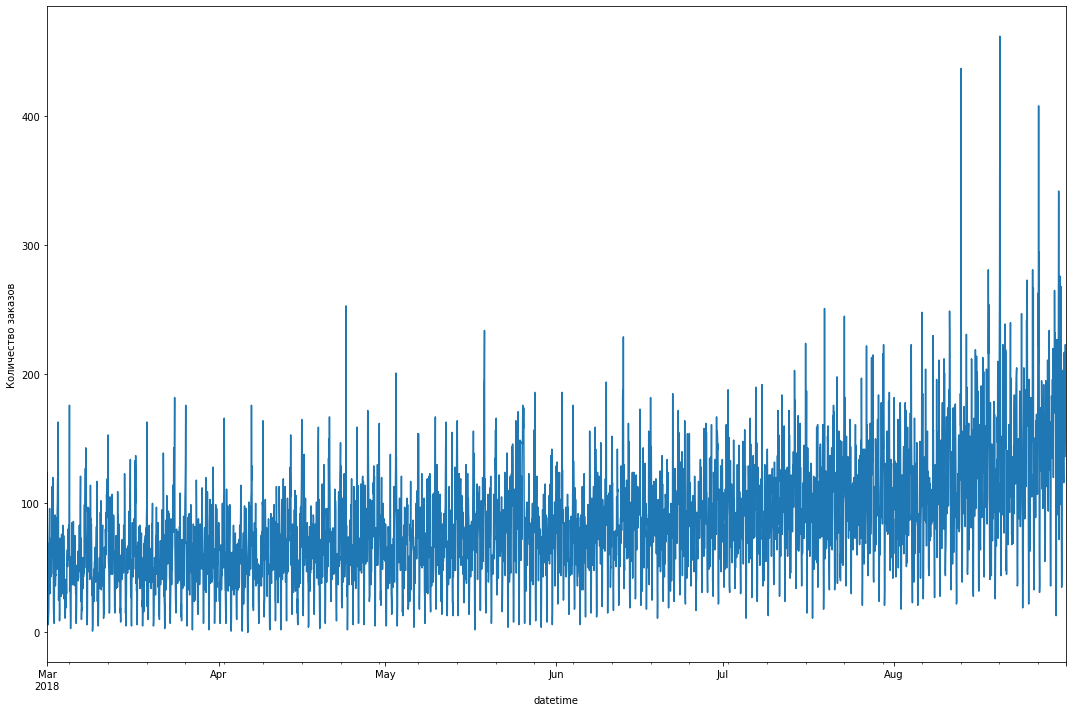

In [9]:
df['num_orders'].plot(figsize=(15,10))
plt.ylabel('Количество заказов')
plt.tight_layout()

Так как имеется сильное колебание значений, чтобы сгладить временный ряд, применим скользящее среднее. Его суть заключается в поиске значений, которые меньше всего подвержены колебаниям, то есть средних арифметических.
В каждой точке вычисляется среднее значение ряда и тем самым сглаживается.

Построим скользящее среднее с количеством окон 168

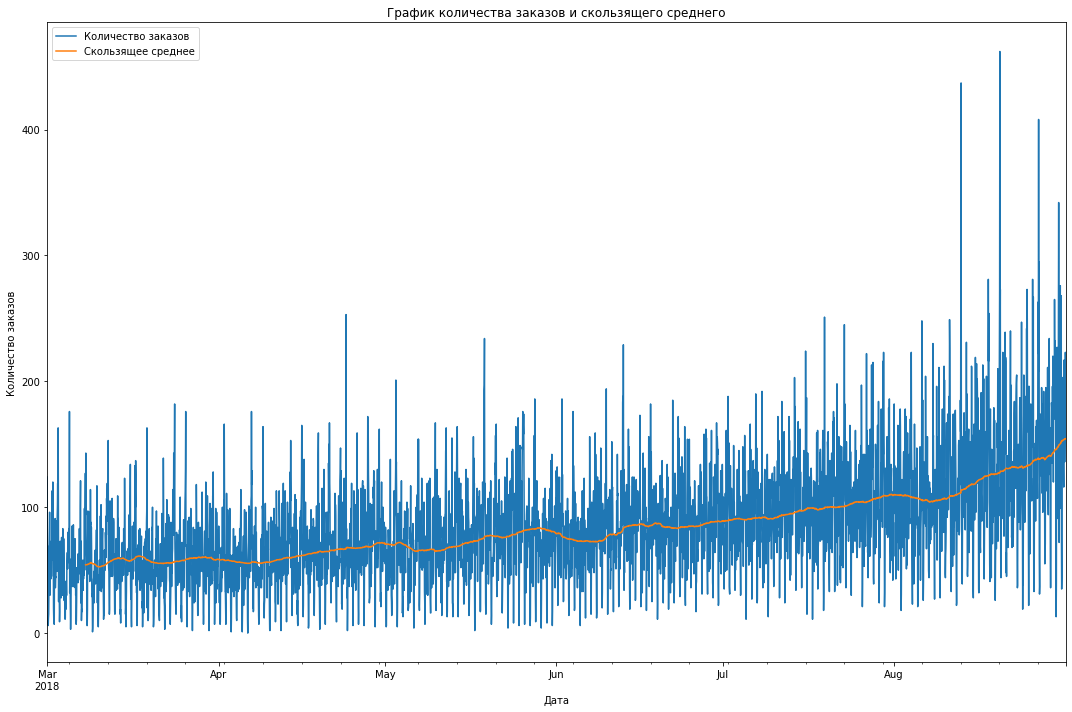

In [10]:
# Строим график количества заказов и скользящего среднего
fig, ax = plt.subplots(figsize=(15, 10))

df['num_orders'].plot(ax=ax, label='Количество заказов')
df['num_orders'].rolling(168).mean().plot(ax=ax, label='Скользящее среднее')

plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('График количества заказов и скользящего среднего')
plt.legend()
plt.tight_layout()
plt.show()

Такой график говорит о колебаниях данных, а благодаря скользящему среднему мы можем уже увидеть предварительно тренд. Проведем исследование сезонности, трендов.

In [11]:
decomposed = seasonal_decompose(df)

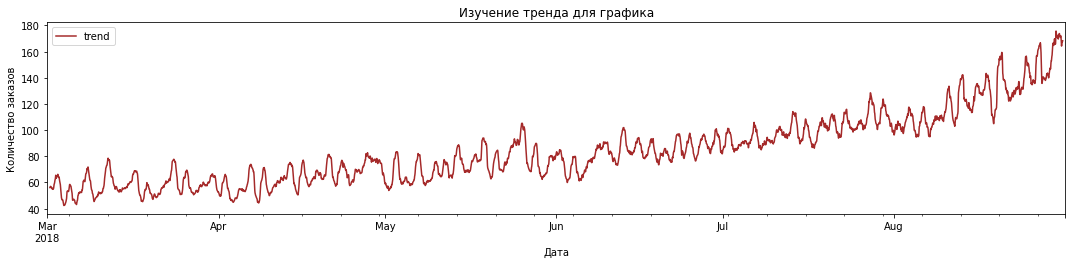

In [12]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(color='brown', ax=plt.gca())  
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Изучение тренда для графика')
plt.legend()
plt.tight_layout()
plt.show()

Можем наблюдать восходящий тренд к летним месяцам. Это связано с тем, что многие жители городов и туристы выходят в отпуск и ездят в  аэропорты и из них.

Тренд мы можем рассмотреть в разрезе одного года, если у нас будут получены данные о нескольких годах, то закономерный рост заказов будет говорить о сезонности.


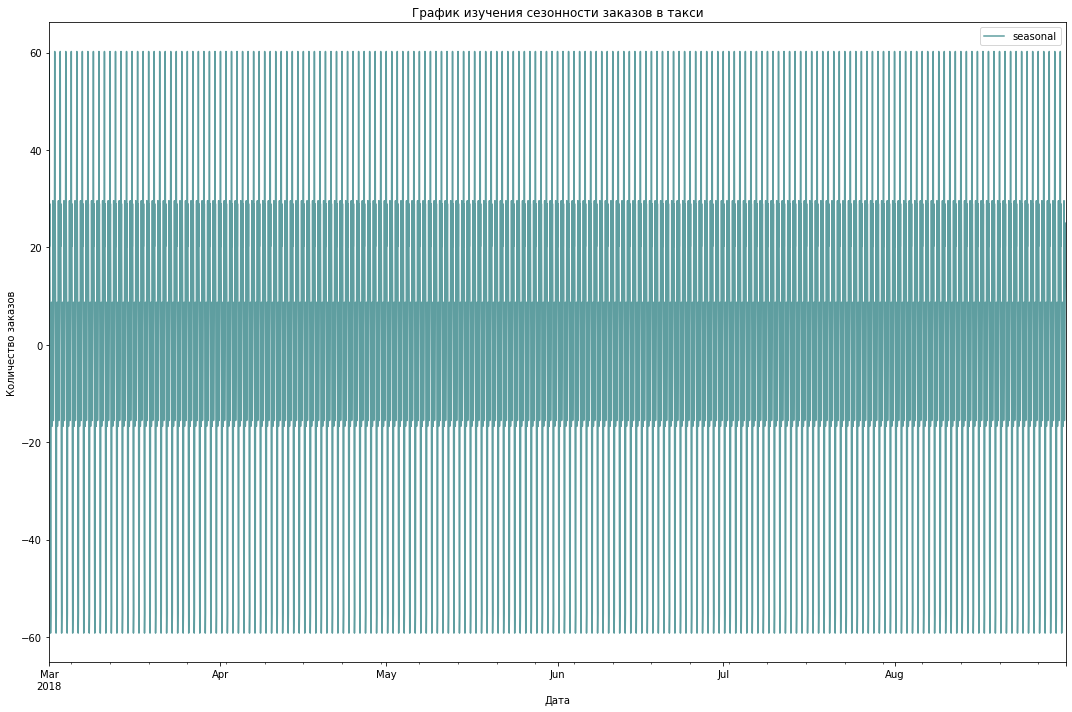

In [13]:
plt.figure(figsize=(15, 10))
decomposed.seasonal.plot(color='cadetblue', ax=plt.gca())  
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('График изучения сезонности заказов в такси')
plt.legend()
plt.tight_layout()
plt.show()

График выглядит неинформативным из-за масштаба, потому считаю необходимым рассмотреть данный график в разрезе каких-либо периодов. Например, в течение месяца или дня.

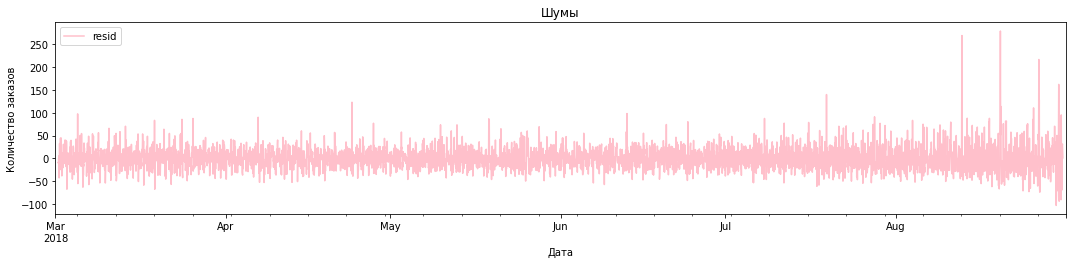

In [14]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.resid.plot(color='pink', ax=plt.gca())  
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Шумы')
plt.legend()
plt.tight_layout()
plt.show()

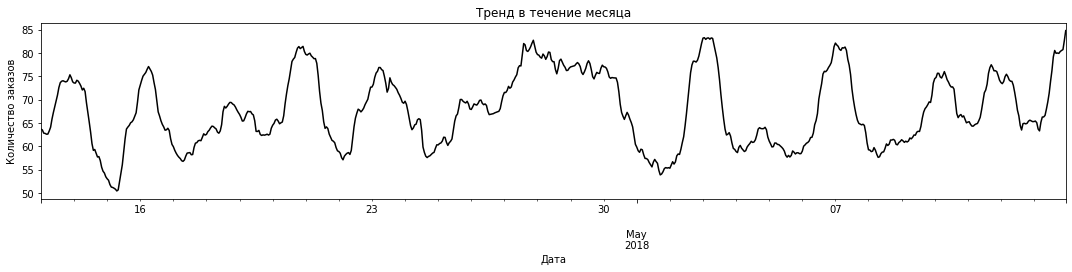

In [15]:
#изучим тренд в течение месяца

plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend['2018-04-13':'2018-05-13'].plot(ax=plt.gca(), color ='black')
plt.title('Тренд в течение месяца') # за месяц
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.tight_layout()

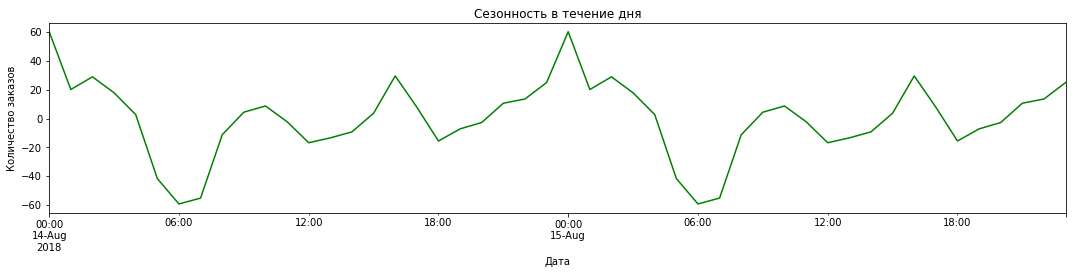

In [16]:
plt.figure(figsize=(15, 10))
plt.subplot(312)

decomposed.seasonal['2018-08-14':'2018-08-15'].plot(ax=plt.gca(), color= 'green')
plt.title('Сезонность в течение дня') # в течение дня
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.tight_layout()

На графике сезонности можно увидеть, как падает количество заказов в утренние часы (06:00), и как растет количество заказов  в вечерние часы (с 18:00).

Для дальнейшего исследования необходимо перевести временный ряд в стационарный.

## Обучение

In [17]:
def make_features(df, max_lag, rolling_mean_size):
   
    data_copy = df.copy(deep=True)
    data_copy['month'] = data_copy.index.month
    data_copy['day'] = data_copy.index.day
    data_copy['dayofweek'] = data_copy.index.dayofweek
    data_copy['hour'] = data_copy.index.hour

    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)

    data_copy['rolling_mean'] = data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    data_copy.dropna(inplace=True)

    return data_copy

In [18]:
df_feat = make_features(df, 24, 168) #для улучшения качества модели будем выбирать лаг 24, а rolling_mean 168
#что соответствует 24 часам и 168 ч. в неделю

Проведем обучение с помощью модели Линейной регрессии, случайного леса и градиентного бустинга с использованием библиотеки CatBoost

In [19]:
df_feat.shape

(4248, 30)

In [20]:
df_feat.tail()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,154.297619
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,154.434524
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,154.285714
2018-08-31 22:00:00,223,8,31,4,22,159.0,154.0,136.0,207.0,217.0,...,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,154.244048
2018-08-31 23:00:00,205,8,31,4,23,223.0,159.0,154.0,136.0,207.0,...,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,154.130952


In [21]:
#Проведем разделение на тестовую и тренировочную выборки

# Выделение целевого признака и разделение выборки:
X = df_feat.drop('num_orders', axis=1)
y = df_feat['num_orders']

# Разбиваем выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=test_size,
    random_state=random_state)

X.shape #всё ли в порядке в процессе разделения

(4248, 29)

### Модель Линейной регрессии

In [22]:
%%time
start_l = time()

lr = LinearRegression()
lr.fit(X_train, y_train)
cv = TimeSeriesSplit(n_splits=10) #Разделили временный ряд на 10 подмножеств

scores = cross_val_score(
    lr,
    X_train,
    y_train,
    cv=cv,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

rmse_lr = (-1) * (sum(scores) / len(scores))
print(f'RMSE на кросс-валидации: {rmse_lr}')

end_l = time()
time_linear_ed = (end_l-start_l)/60


RMSE на кросс-валидации: 26.67743174546244
CPU times: user 893 ms, sys: 1.04 s, total: 1.94 s
Wall time: 3.81 s


### Модель Случайный лес

In [23]:
%%time
start_t = time()

pipe_rf = Pipeline([
    ('models', RandomForestRegressor(random_state=random_state))
])

tree_par = {
    'models': [RandomForestRegressor(random_state=random_state)],
    'models__n_estimators': range(50, 100, 5),
    'models__max_depth': range(3, 8),
    'models__min_samples_leaf': range(5, 50, 5),
}

tree = RandomizedSearchCV(
    pipe_rf,
    tree_par,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=10,
    cv=cv,
    verbose=0,
    random_state=random_state,
)

tree.fit(X_train, y_train)

# выведите лучшие гиперпараметры
print('Лучшая модель: \n', tree.best_estimator_)
# выведите лучшую метрику качества
print('RMSE на кросс-валидации', (-1) * tree.best_score_)

end_t=time()

time_random_ed = (end_t - start_t)/60

Лучшая модель: 
 Pipeline(steps=[('models',
                 RandomForestRegressor(max_depth=6, min_samples_leaf=15,
                                       n_estimators=85, random_state=42))])
RMSE на кросс-валидации 25.728388655705878
CPU times: user 1min 52s, sys: 409 ms, total: 1min 53s
Wall time: 11min 24s


### CatBoostRegressor

In [24]:

catboost_reg = CatBoostRegressor(random_state=random_state,cat_features = None, verbose=False)
catboost_reg.fit(X_train, y_train)
 

In [25]:
%%time
start_cb_ed = time()

cb_scores = cross_val_score(
    catboost_reg,
    X_train,
    y_train,
    cv=cv,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

cv_catboost = sum(cb_scores) / len(cb_scores)
print('RMSE на кросс-валидации :', (-1) * cv_catboost)

end_cb_ed = time()

time_cb_ed = (end_cb_ed  - start_cb_ed)/60    

RMSE на кросс-валидации : 23.40364507879556
CPU times: user 1min 9s, sys: 1.72 s, total: 1min 11s
Wall time: 9min 16s


In [26]:
#Создадим объединенную таблицу, куда внесём данные по исследуемым моделям:
time_to_choose = {
    'Модель': ['LinearRegression', 'CatBoostRegressor', 'RandomForestRegressor'],
    'Время предсказания': [time_linear_ed, time_cb_ed, time_random_ed],
    'RMSE на кросс-валидации': [26.67, 23.40, 25.73]
}

top_list = pd.DataFrame(time_to_choose)
top_list

,Модель,Время предсказания,RMSE на кросс-валидации
0,LinearRegression,0.063416,26.67
1,CatBoostRegressor,9.278287,23.40
2,RandomForestRegressor,11.404806,25.73


**Вывод по обучению моделей:**

1) Модель линейной регрессии хоть и обучает быстро, но её значение метрики самое высокое.

2) Поэтому, если рассматривать модели, прошедшие порог метрики, то из них лучше всего выбрать модель CatBoostRegressor, так как она быстро предсказывает и ошибается на меньшее число заказов, но нужно проверить, как она справится на тестовой выборке:



## Тестирование

In [27]:
%%time
start_cb=time()
# Применим выбранную модель к тестовой выборке:
y_pred_cat = catboost_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred_cat)
rmse = mse ** 0.5  # Расчет метрик
print('RMSE на тестовой выборке:', rmse)
end_cb= time()

time_cb=(end_cb  - start_cb)/60 

RMSE на тестовой выборке: 40.42601210438084
CPU times: user 2.66 ms, sys: 4.01 ms, total: 6.67 ms
Wall time: 6.86 ms


Таким образом, можно сделать вывод, что выбор модели CatBoostRegressor является верным, так как модель не только показала хорошее значение метрики RMSE (40,42), но и очень быстро сделала предсказание, что удовлетворит требованиям заказчика.





## Общий вывод по проекту

При загрузке данных сделаны следующие выводы:

- датасет содержит 26496 записей

- наименования столбцов соответствуют змеиному регистру, переименовывать не потребуется

- пропуски отсутствуют

- явные дубликаты отсутствуют

- описательная статистика продемонстрировала, что количество заказов в какой-то из дней могло быть 0 (на самом деле сложно представить, но посмотрим далее, является ли это аномалией)

Так как по запросу заказчика необходимо спрогнозировать количество заказов в следующий час, а в датасете шаг 10 минут, то необходимо было провести ресемплирование, но предварительно проверили на монотонность.
Провели семплирование на 1 час, 
Так как имеется сильное колебание значений, чтобы сгладить временный ряд, применим скользящее среднее. Его суть заключается в поиске значений, которые меньше всего подвержены колебаниям, то есть средних арифметических. В каждой точке вычисляется среднее значение ряда и тем самым сглаживается.

Построили скользящее среднее с количеством окон 168
В графике наблюдались колебаниях данных, а благодаря скользящему среднему мы увидели предварительно тренд. Провелиисследование сезонности, трендов.
Можем наблюдать восходящий тренд к летним месяцам. Это связано с тем, что многие жители городов и туристы выходят в отпуск и ездят в аэропорты и из них.

На графике сезонности увидели, как падает количество заказов в утренние часы (06:00), и как растет количество заказов в вечерние часы (с 18:00).

Для дальнейшего исследования необходимо было перевести временный ряд в стационарный.
Провели обучение с помощью модели Линейной регрессии, случайного леса и градиентного бустинга с использованием библиотеки CatBoostRegressor

**Вывод по обучению моделей:**

1) Модель линейной регрессии хоть и обучает быстро, но её значение метрики RMSE не удовлетворяет требованиям заказчика.

2) Поэтому, если рассматривать модели, прошедшие порог метрики, то из них лучше всего выбрать модель CatBoostRegressor, так как она быстро предсказывает и ошибается на меньшее число заказов, но нужно проверить, как она справится на тестовой выборке:

Таким образом, можно сделать вывод, что выбор модели CatBoostRegressor является верным, так как модель не только показала хорошее значение метрики RMSE (40,42), но и очень быстро сделала предсказание, что удовлетворит требованиям заказчика.